In [220]:
%matplotlib inline

In [221]:
import redqueen.opt_model as OM
import redqueen.opt_runs as OR
import redqueen.utils as RU
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import decorated_options as Deco
import multiprocessing as MP

In [222]:
sns.set_style(style='dark')
sns.set_palette('Set2')

In [223]:
from importlib import reload
reload(OM)
reload(OR)
reload(RU)

<module 'redqueen.utils' from '/NL/stackexchange/work/prog/broadcast-online/redqueen/utils.py'>

In [224]:
OR.SimOpts(**{
        'src_id': 1,
        'q_vec': [],
        's': 1.0,
        'other_sources': [
            (
                'Poisson', 
                {
                    'src_id': 2,
                    'seed': 42,
                    'rates': 100
                }
            )
        ],
        'sink_ids': [1001],
        'end_time': 100.0,
        'edge_list': [(1, 1001), (2, 1001)]
    })

In [225]:
simOpts = OR.SimOpts.std_poisson(42, 1000)

# Exponential sampler

The output intensity is given by:

$$
u(t) = \exp( \underbrace{W_h \cdot h_j}_{\text{past}} - \overbrace{W_t (t - t_j)}^{\text{decay}} + \underbrace{b_t}_{\text{base}} )
$$

where $t_j$ is the last event before $t$.

It is simplified to the following in the code:

$$
u(t) = c \cdot e^{- W_t \cdot (t - t_j)}
$$

In [7]:
%run -i tpprl/exp_sampler.py

Testing the sampler.

In [8]:
def_plot_opts = Deco.Options(vt=0.5, 
                             wt=1.0,
                             bt=1.0,
                             init_h=0,
                             t_min=0,
                             t_max=10,
                             resolution=200)

@Deco.optioned()
def plot_lambda(vt, wt, bt, init_h, t_min, t_max, events, resolution):
    X = np.linspace(t_min, t_max, num=resolution)
    
    
    event_idx = 0
    c = np.exp(vt * init_h + bt)
    t0 = t_min
    
    # TODO: In the baseilne, shouldn't the t_0 still be updated to the latest event?
    Y1 = [c * np.exp(-wt * (x - t0)) for x in X]
    
    Y2 = [None] * len(X)
    for idx, x in enumerate(X):
        while event_idx < len(events) and events[event_idx][0] < x:
            c = np.exp(vt * events[event_idx][1] + bt)
            t0 = events[event_idx][0]
            event_idx += 1
            
        Y2[idx] = c * np.exp(-wt * (x - t0))
    
    plt.step(X, Y1, '--', label='Baseline')
    plt.step(X, Y2, '-', label='Correct')
    plt.vlines([x[0] for x in events], ymin=0, ymax=max(Y2), label='Events')
    plt.legend()
    return (X, Y1, Y2)

In [9]:
events = [(1, -8), (5, 5), (9, 0)]

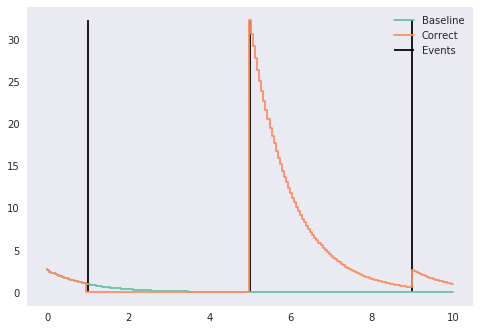

In [10]:
X, Y1, Y2 = plot_lambda(events=events, _opts=def_plot_opts)

In [11]:
sampler = ExpCDFSampler(_opts=def_plot_opts, seed=101 + 1279)

In [12]:
sampler.generate_sample()

0.6092880541958573

In [13]:
sampler.reset_only_sample(sampler.generate_sample())

0.98369540000156641

In [14]:
sampler.reset(1, -4, False)

0.9725887021550208

In [15]:
sampler.register_event(5, 0.5, False)

4.924794439657469

In [16]:
sampler.reset_only_sample(sampler.generate_sample())

4.9482122321618336

In [17]:
sampler.register_event(9, 0, False)

8.7893001591946209

In [18]:
sampler.reset_only_sample(sampler.generate_sample())

9.0386156318159898

In [19]:
sampler.generate_sample()

9.0386156318159898

## Tests

In [20]:
%%time
all_sim_events = []
processes = None
N = 10000
verbose = False

assert not verbose or (N < 10 and processes is not None), "Cannot have verbose output with these settings."

def worker_sampler(params):
    ii, sampler = params
    event_idx = 0
    next_sample = sampler.generate_sample()
    sim_events = []
        
    while next_sample < def_plot_opts.t_max or event_idx < len(events):
        while event_idx < len(events) and \
              events[event_idx][0] < next_sample:
            # print("Old = ", next_sample)
            old_sample = next_sample
            next_sample = sampler.register_event(events[event_idx][0], 
                                                 events[event_idx][1], 
                                                 False)
            if verbose:
                print("Eps = {}, Old = {}, Event = {}, Next = {}"
                      .format(ii, old_sample, events[event_idx], next_sample))
                
            event_idx += 1
            
        if next_sample > def_plot_opts.t_max:
            break
            
        if verbose:
            print("Final sample = {}".format(next_sample))                
        
        sim_events.append(next_sample)
        next_sample = sampler.reset_only_sample(next_sample)
    
    return sim_events
    

with MP.Pool(processes=processes) as pool:
    for sim_events in pool.map(worker_sampler,
                               [(ii, ExpCDFSampler(_opts=def_plot_opts, seed=101 + ii))
                                for ii in range(N)]):
        all_sim_events.append(sim_events)


CPU times: user 1.23 s, sys: 467 ms, total: 1.7 s
Wall time: 1.85 s


In [21]:
flat_events = [x for y in all_sim_events for x in y]

In [22]:
[x for x in flat_events if x < 0]

[]

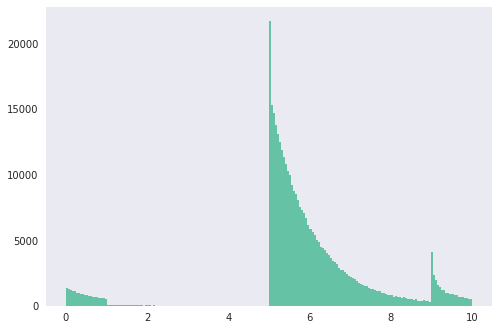

In [23]:
plt.hist(flat_events, bins=200);

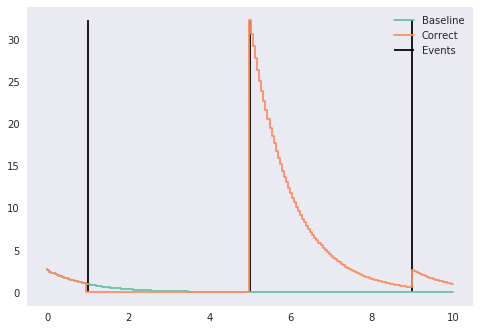

In [24]:
X, Y1, Y2 = plot_lambda(events=events, _opts=def_plot_opts)

In [26]:
len(all_sim_events)

10000

## ExpCDFBroadcaster

In [226]:
class ExpBroadcasterOld(OM.Broadcaster):
    
    @Deco.optioned()
    def __init__(self, src_id, seed, vt, wt, bt, init_h, t_min=0):
        super(ExpBroadcasterOld, self).__init__(src_id, seed)
        self.init = False
        self.vt = vt
        self.wt = wt
        self.bt = bt
        self.init_h = init_h
        self.exp_sampler = ExpCDFSampler(vt=vt, wt=wt, bt=bt,
                                         init_h=init_h, t_min=t_min, seed=seed)
        
    def get_next_interval(self, event):
        if not self.init:
            self.init = True
            # Nothing special to do for the first event.
            
        self.state.apply_event(event)
        
        if event is None:
            # This is the first event. Post immediately to join the party?
            # Or hold off?
            return self.exp_sampler.generate_sample()
        elif event.src_id == self.src_id:
            # We posted.
            hidden_state = self.exp_sampler.get_last_hidden_state()
            new_hidden_state = self.random_state.randn(*hidden_state.shape)
            self.exp_sampler.register_event(time=self.get_current_time(event), 
                                            new_h=hidden_state,
                                            own_event=True)
        else:
            # Have to update the hidden state and the t0 of our ExpSampler
            return None # Preserve the old time

In [227]:
OM.SimOpts.registerSource('ExpBroadcasterOld', ExpBroadcasterOld)

In [228]:
RS = np.random.RandomState(420)

simOpts = OM.SimOpts(
   src_id = 1,
   end_time = 100, # When the simulations stop
   q_vec = np.asarray([1.0, 1.0]), # Weights of followers
   s = 1.0, # Control parameter for RedQueen
   sink_ids = [1, 2],
   other_sources = [
      ('ExpBroadcasterOld', 
       {'src_id': 2,
        'seed': 42,
        'wt': 0.5,
        'init_h': 0.1 * RS.randn(10),
        'vt': 0.1 * RS.randn(10),
        'bt': 1.0,
       }
      ),
      ('Hawkes',
       {'src_id': 3,
        'seed': 43,
        'alpha': 0.01 * np.exp(RS.randn(10).dot(RS.randn(10))),
        'beta': 0.5,
        'l_0': np.exp(1.0)
       }
      )
   ],
   edge_list=[(1, 1), (1, 2), 
              (2, 1), (2, 2),
              (3, 1), (3, 2)]
)

In [30]:
mgr = simOpts.create_manager_with_opt(seed=6)

In [31]:
%%time
mgr.run_dynamic()

CPU times: user 153 ms, sys: 3.33 ms, total: 157 ms
Wall time: 150 ms


In [32]:
df = mgr.get_state().get_dataframe()

In [33]:
df.head()

,event_id,sink_id,src_id,t,time_delta
0,100,1,1,0.000000,0.000000
1,100,2,1,0.000000,0.000000
2,101,1,3,0.044966,0.044966
3,101,2,3,0.044966,0.044966
4,102,1,3,0.097634,0.052668


In [34]:
df.groupby('src_id').size()

src_id
1     614
2    1174
3     520
dtype: int64

# Reinf broadcaster

In [23]:
iterSession = tf.InteractiveSession()

In [96]:
iterSession.run(tf.one_hot([0,1], depth=1, dtype=tf.float32))

RuntimeError: Graph is finalized and cannot be modified.

In [97]:
input_dim = 1
hidden_dim = 16

class ReinfNetwork():
    def __init__(self, s_size, scope, trainer):
        with tf.variable_scope(scope):
            self.event_source = tf.placeholder(dtype=tf.int64, name='Event source', shape=[1])
            self.inp = tf.one_hot(indices=[self.event_source], depth=1, dtype=tf.float32)
            self.cell = tf.contrib.rnn.BasicRNNCell(hidden_dim)
            self.Wh = tf.get_variable('Wh', shape=)            

SyntaxError: invalid syntax (<ipython-input-97-5ada64ef1d8c>, line 10)

In [25]:
class Reinf(OM.Broadcaster):
    
    @Deco.optioned()
    def __init__(self, src_id, seed, hidden_dim):
        super(Reinf, self).__init__(src_id, seed)
        self.init = False
        
        self.Wh = tf.get_variable()
        
    def get_next_interval(self, event):
        if not self.init:
            # Create variables here?
            self.init = True
        
        self.state.apply_event(event)
        
        if event is None:
            # This is the first event. Post immediately to join the party?
            # Or hold off?
            return np.inf
        
        elif event.src_id == self.src_id:
            # We posted. Calculate reward.
            # We would never like to post now.
            return np.inf
        
        else:
            # Update our rate of posting.
            r_t = self.state.get_wall_rank(self.src_id, self.sink_ids,
                                           dict_form=False)
            # TODO: Magic.
            #  1 - Reward for this interval?
            #  2 - Sample the posting time again using inverse CDF
            #  3 - New sample is guaranteed to be closer to now than
            #      the original posting time.
            cur_time = event.cur_time
            t_delta_new = 10 # TODO: Take a new sample here.
            return cur_time + t_delta_new - self.last_self_event_time
        
    def train(self):
        """Will do RL here."""
        pass
            


In [26]:
mgr = simOpts.create_manager_with_broadcaster(Reinf(1, 100))

In [27]:
mgr.run_dynamic()

In [28]:
df = mgr.state.get_dataframe()

In [29]:
df.head()

,event_id,sink_id,src_id,t,time_delta
0,100,1001,2,0.004632,0.004632
1,101,1001,2,0.005062,0.000430
2,102,1001,2,0.005522,0.000461
3,103,1001,2,0.006952,0.001430
4,104,1001,2,0.009197,0.002245


# ExpTrainer

In [375]:
%run -i tpprl/exp_broadcaster.py

In [376]:
tf.reset_default_graph()

In [377]:
iterSession.close()

In [378]:
iterSession = tf.Session()

In [379]:
hidden_dims = 10
num_other_broadcasters = 1
RS = np.random.RandomState(seed=42)

trainer_opts = Deco.Options(
    Wh=RS.randn(hidden_dims, hidden_dims) * 0.1 + np.diag(np.ones(hidden_dims)), # Careful initialization
    Wm=RS.randn(num_other_broadcasters + 1, hidden_dims),
    Wr=RS.randn(hidden_dims, 1),
    Wt=RS.randn(hidden_dims, 1),
    Bh=RS.randn(hidden_dims, 1),
    
    vt=RS.randn(hidden_dims, 1),
    wt=np.abs(RS.rand(1)),
    bt=RS.randn(1),
    
    init_h=RS.randn(hidden_dims),
    
    max_events=5,
    batch_size=2
)
sim_opts = OM.SimOpts(
    sink_ids=[1000],
    src_id=1,
    other_sources=[('Hawkes', {'src_id': 100, 'seed': 93})],
    end_time=100.0,
    q_vec=None,
    s=1.0,
    edge_list=None
)

trainer = ExpRecurrentTrainer(sim_opts=sim_opts, _opts=trainer_opts, sess=iterSession)

In [380]:
trainer.initialize(finalize=False)

In [346]:
tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

[<tf.Variable 'ExpRecurrentTrainer/hidden_state/Wm:0' shape=(2, 10) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/hidden_state/Wh:0' shape=(10, 10) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/hidden_state/Wt:0' shape=(10, 1) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/hidden_state/Wr:0' shape=(10, 1) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/hidden_state/Bh:0' shape=(10, 1) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/hidden_state/h:0' shape=(10, 1) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/output/bt:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/output/vt:0' shape=(10, 1) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/output/wt:0' shape=(1,) dtype=float32_ref>]

In [311]:
df = trainer.run_sim(42)

In [312]:
df2 = trainer.run_sim(43)

In [313]:
trainer.reward_fn(df)

223696.51133606216

In [327]:
f_d = trainer.get_feed_dict([df, df2])

In [315]:
trainer.sess.run(trainer.tf_wt)

array([ 0.71217924], dtype=float32)

In [316]:
trainer.sess.run(trainer.loss, feed_dict=f_d)

array([ 1.12259722,  1.34741533], dtype=float32)

In [317]:
trainer.sess.run(trainer.LL, feed_dict=f_d)

array([-77.3717804 , -77.38252258], dtype=float32)

In [318]:
h_states, LL_log_terms, LL_int_terms, loss_terms = \
    trainer.sess.run([trainer.h_states, trainer.LL_log_terms, trainer.LL_int_terms, trainer.loss_terms],
                     feed_dict=f_d)

In [243]:
h_states

[array([[-0.56857789,  0.87188947, -0.97570437,  0.4127129 , -0.24575326,
          0.92805529, -0.92910945, -0.90461588,  0.75090462, -0.36737645],
        [ 0.06203905,  0.86417949, -0.9371953 ,  0.21917151,  0.1670471 ,
          0.73383152, -0.86028886, -0.87407959,  0.53977203,  0.17443067]], dtype=float32),
 array([[-0.74964964,  0.97515643, -0.99486661,  0.66084003, -0.32035458,
          0.98164982, -0.98546612, -0.98095316,  0.91558212, -0.49091104],
        [-0.77941978,  0.97574413, -0.99785733,  0.67731714, -0.33509138,
          0.99347496, -0.99188447, -0.98559117,  0.9382813 , -0.5049631 ]], dtype=float32),
 array([[-0.80943024,  0.97978187, -0.99508929,  0.76674902, -0.37377241,
          0.98172915, -0.98583323, -0.9824326 ,  0.93501163, -0.56479216],
        [-0.82032669,  0.97925359, -0.99489534,  0.77671045, -0.38317883,
          0.9840281 , -0.98722285, -0.98348629,  0.93988305, -0.58258569]], dtype=float32),
 array([[-0.56394756,  0.97877687, -0.98936826,  0.7485

In [244]:
np.hstack([x[:, np.newaxis] for x in LL_log_terms])

array([[ 0.        , -4.01316738,  0.        , -3.94328713, -4.02441645,
         0.31243208, -4.27579641, -4.37533092, -3.68224812, -4.33269072,
        -4.36058664, -4.18507242, -3.48860955, -4.25126839, -3.774122  ,
        -3.85163903, -2.66653538, -4.43087196, -4.30483532, -4.35969925,
        -4.26708698, -4.20578384, -2.84365845, -4.36191797, -4.38638163,
        -4.25179863, -4.30749798, -4.2060256 , -4.29222775, -4.0436902 ,
        -4.41335726, -4.19760704, -4.18787527, -4.24986839, -4.15276003,
         0.        , -3.65046859, -3.78290892, -4.23813868, -4.1613369 ,
        -4.24144459, -3.92261839, -3.98891902, -2.36379218, -4.12030745,
        -4.38511419, -4.10747719, -4.33680344, -4.36656094, -4.19544125,
        -4.38197613, -4.27634382, -4.34637403, -4.29690695, -4.06028986,
        -3.80248237, -3.34022593, -3.42152333, -4.23725605, -4.36004114,
        -3.69040132, -4.45399857, -4.21430254, -3.96188283, -3.85395503,
        -4.4084816 , -3.69584203, -4.47465229, -3.7

In [131]:
np.hstack([x[:, np.newaxis] for x in LL_int_terms])

array([[  3.53749394e-02,   3.01899132e-03,   1.82716035e+04,
         -0.00000000e+00,   3.34786558e+00],
       [  2.80396901e-02,   9.70880967e-04,   9.05402973e-02,
         -0.00000000e+00,   1.63995840e+07]], dtype=float32)

In [134]:
np.hstack([x[:, np.newaxis] for x in loss_terms])

array([[  2.28893524e-03,   2.42241385e-05,   4.38065101e+09,
         -0.00000000e+00,   3.86745529e+01],
       [  8.06720462e-03,   1.16220224e-06,   2.24592313e-02,
         -0.00000000e+00,   3.67718490e+14]], dtype=float32)

In [268]:
LL_int_terms

[array([ 0.07122578,  0.0374492 ], dtype=float32),
 array([ 0.00578567,  0.0143473 ], dtype=float32),
 array([ 0.01224425,  0.00254374], dtype=float32),
 array([ 0.0001477 ,  0.00131983], dtype=float32),
 array([ 0.00682765,  0.7514624 ], dtype=float32),
 array([ 1.02680361,  0.00122536], dtype=float32),
 array([ 0.00107339,  0.000503  ], dtype=float32),
 array([ 0.00045441,  0.0058391 ], dtype=float32),
 array([ 0.00513659,  0.00140193], dtype=float32),
 array([ 0.0014001 ,  0.00037832], dtype=float32),
 array([ 0.00037852,  0.00204236], dtype=float32),
 array([ 0.00204256,  0.00785597], dtype=float32),
 array([ 0.00785388,  0.00197879], dtype=float32),
 array([ 0.00197896,  0.00523644], dtype=float32),
 array([ 0.00523653,  0.0046431 ], dtype=float32),
 array([ 0.00464319,  0.02109089], dtype=float32),
 array([ 0.02109053,  0.00061031], dtype=float32),
 array([ 0.00061037,  0.00134548], dtype=float32),
 array([ 0.00134555,  0.00041672], dtype=float32),
 array([ 0.00041675,  0.0005634

In [100]:
df.t.iloc[-1]

99.486486816163847

In [272]:
%%time
LL_grads = iterSession.run(trainer.LL_grads, feed_dict=f_d)
loss_grads = iterSession.run(trainer.loss_grads, feed_dict=f_d)

In [275]:
LL_grads

{<tf.Variable 'ExpRecurrentTrainer/hidden_state/Wh:0' shape=(10, 10) dtype=float32_ref>: [array([[ -2.99606800e+00,  -3.71909976e+00,   1.33702028e+00,
           -1.39037979e+00,   2.38318825e+00,   5.02713108e+00,
           -4.98379850e+00,  -5.02480364e+00,   5.00027657e+00,
           -4.75504494e+00],
         [ -4.26948833e+00,   6.26499414e-01,  -3.67279363e+00,
           -2.40540743e+00,   5.53412390e+00,   1.09491434e+01,
           -7.16436386e+00,  -1.08532867e+01,   1.05527220e+01,
           -7.23006105e+00],
         [  6.11900234e+00,  -2.49526954e+00,   5.35612297e+00,
           -2.09307718e+00,  -2.65487337e+00,  -8.32765388e+00,
            6.56142616e+00,   8.27307034e+00,  -8.13354778e+00,
            5.22924948e+00],
         [ -4.23263025e+00,   5.24473786e-01,  -2.38811493e+00,
            5.79427004e-01,   2.33740950e+00,   4.85080910e+00,
           -3.52857614e+00,  -4.82357693e+00,   4.70750713e+00,
           -3.39204454e+00],
         [ -5.24386501e+00, 

In [274]:
for x in LL_grads.values():
    print(np.any(np.isnan(x)))

False


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [273]:
loss_grads

{<tf.Variable 'ExpRecurrentTrainer/hidden_state/Wh:0' shape=(10, 10) dtype=float32_ref>: [array([[  1.52078399e-03,  -8.11053440e-04,   1.08194584e-03,
           -1.11959630e-03,  -4.97454967e-05,  -1.34236796e-03,
            1.15430343e-03,   1.32803514e-03,  -1.31437834e-03,
            6.38694619e-04],
         [ -2.47407869e-01,   1.26101434e-01,  -1.93560109e-01,
            1.92888841e-01,   5.71228266e-02,   2.51808852e-01,
           -2.23592535e-01,  -2.50025660e-01,   2.46770248e-01,
           -1.05699554e-01],
         [  2.01973459e-03,   4.28064680e-03,  -3.90762137e-03,
            2.08477536e-03,  -3.32420762e-03,  -2.43721879e-03,
            2.99048843e-03,   2.49160547e-03,  -2.49824836e-03,
            3.38118197e-03],
         [ -1.71623722e-01,  -6.50273412e-02,   3.88583541e-02,
            1.32735679e-02,   1.11823775e-01,   1.79444462e-01,
           -1.74518257e-01,  -1.79421782e-01,   1.78024441e-01,
           -1.43800288e-01],
         [  6.73932657e-02, 

In [381]:
true_grads = trainer.get_batch_grad([df, df2])

In [382]:
true_grads

[{<tf.Variable 'ExpRecurrentTrainer/hidden_state/Wh:0' shape=(10, 10) dtype=float32_ref>: array([[ -2.02311797e+04,   1.03143096e+04,  -1.26128457e+04,
            1.18811045e+04,   5.04598096e+03,   2.07568926e+04,
           -1.64309668e+04,  -2.06734043e+04,   2.05089863e+04,
           -6.16192725e+03],
         [ -3.28419750e+05,   2.73562781e+05,  -2.99969156e+05,
            8.39488594e+04,  -4.97276016e+04,   3.31712656e+05,
           -1.13095141e+05,  -3.24829094e+05,   3.20951594e+05,
           -6.93336875e+04],
         [  4.95181969e+05,  -3.97066562e+05,   4.31909500e+05,
           -2.13073797e+05,   3.12167012e+04,  -5.02031531e+05,
            2.72991594e+05,   4.96667844e+05,  -4.91844844e+05,
            8.74924219e+04],
         [ -2.59434719e+05,   1.84411469e+05,  -2.11444953e+05,
            4.55773789e+04,  -1.66397090e+04,   2.62809531e+05,
           -7.30018359e+04,  -2.56627938e+05,   2.53408016e+05,
           -8.01454375e+04],
         [ -4.24339094e+05, 

In [374]:
%debug

> /home/utkarshu/prog/work/broadcast-rl/tpprl/exp_broadcaster.py(321)get_batch_grad()
    319                     np_loss_grad = loss_grad
    320 
--> 321                 batch_grad[x] = (reward + loss) * np_LL_grad + np_loss_grad
    322 
    323             true_grads.append(batch_grad)

ipdb> x
<tf.Variable 'ExpRecurrentTrainer/hidden_state/Wh:0' shape=(10, 10) dtype=float32_ref>
ipdb> reward
223696.51133606216
ipdb> loss
0.34115934
ipdb> np_LL_grad
[array([[ -9.04401094e-02,   4.61084209e-02,  -5.63836321e-02,
          5.31124845e-02,   2.25571916e-02,   9.27902088e-02,
         -7.34518692e-02,  -9.24169943e-02,   9.16819870e-02,
         -2.75458544e-02],
       [ -1.46814597e+00,   1.22291708e+00,  -1.34096241e+00,
          3.75279397e-01,  -2.22299084e-01,   1.48286641e+00,
         -5.05572975e-01,  -1.45209455e+00,   1.43476093e+00,
         -3.09944719e-01],
       [  2.21362877e+00,  -1.77502024e+00,   1.93077993e+00,
         -9.52510893e-01,   1.39549285e-01,  -2.24424

In [351]:
tf.reset_default_graph()
x = tf.get_variable('x', shape=[], dtype=tf.float32)
y = tf.constant(np.asarray([[0, 1]]), dtype=tf.float32) + x

In [355]:
iterSession = tf.InteractiveSession()

In [357]:
tf.gradients?

In [356]:
iterSession.run(tf.gradients(y, x), feed_dict={x: 4})

[2.0]

In [365]:
tf.split?

In [364]:
iterSession.run([tf.gradients(y_, x) for y_ in tf.split(y, 2, axis=1)])

[[1.0], [1.0]]

In [358]:
tf.AggregationMethod.

tensorflow.python.ops.gradients_impl.AggregationMethod

In [366]:
trainer.LL

<tf.Tensor 'add_5:0' shape=(2,) dtype=float32>